In [27]:
###Packages to manipulate data
import pandas as pd
import numpy as np

###Visualization Packages
###Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install missingno
import missingno
from matplotlib import pyplot as plt
import seaborn as sns


###data transformation packages
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

###ML algos
from sklearn import model_selection
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

In [3]:
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')
sample_submission = pd.read_csv('gender_submission.csv')

**Exploring the data**

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data_bins = pd.DataFrame()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


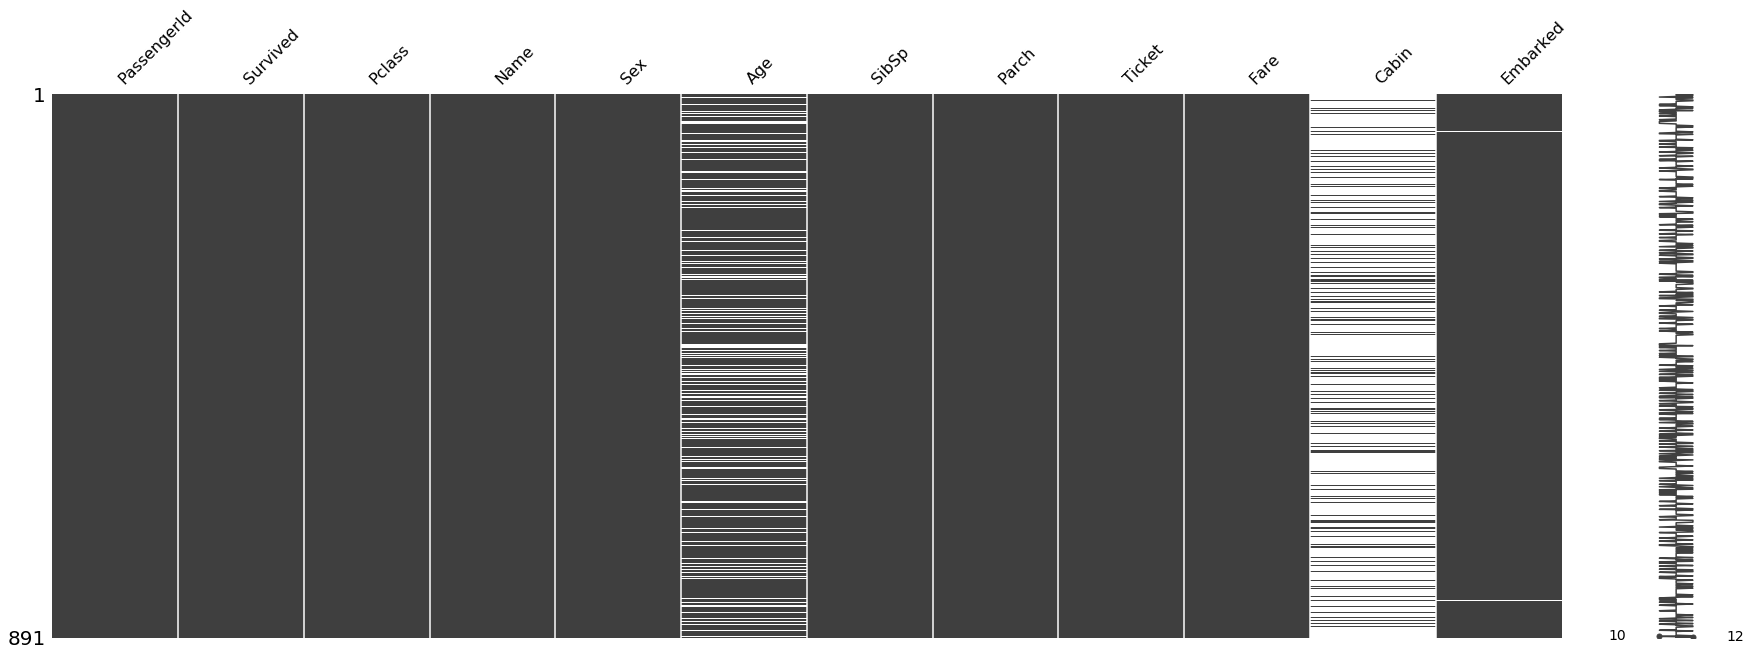

In [6]:
print(train_data.isna().sum())
missingno.matrix(train_data,figsize=(30,10))

In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [8]:
##No null values in the Survived column, added to data_bins
print(train_data['Survived'].value_counts())
data_bins['Survived'] = train_data['Survived']

0    549
1    342
Name: Survived, dtype: int64


In [9]:
##No null values and clearly all passengers belonged to one of the classes - 1,2,or3. Added to data_bins
train_data['Pclass'].value_counts()
data_bins['Pclass'] = train_data['Pclass']

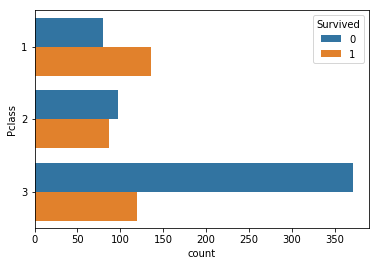

In [10]:
sns.countplot(y=train_data['Pclass'],hue=train_data['Survived'])
##1st Class has highest %survivers and in 3rd class most people perished 

In [11]:
###The name column has all unique values and will not add any value to predictive models, instead the title could be useful
train_data['title']=train_data['Name'].apply(lambda val: val.split(',')[1].split('.')[0].strip())
train_data['title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Sir               1
Ms                1
the Countess      1
Mme               1
Don               1
Capt              1
Jonkheer          1
Lady              1
Name: title, dtype: int64

In [12]:
train_data['title'].replace({'Ms':'Miss'},inplace=True)
train_data['title'].replace(['Dr','Rev','Major','Col','Mlle','Lady','Mme','Capt','Jonkheer','the Countess','Don','Sir'],'Top',
                            inplace=True)
train_data['title'].value_counts()
#the field has no missing values

Mr        517
Miss      183
Mrs       125
Master     40
Top        26
Name: title, dtype: int64

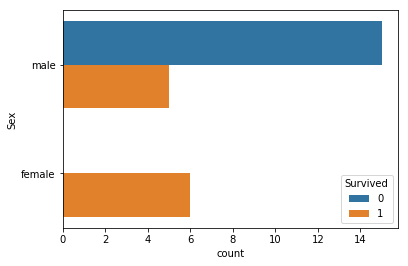

In [13]:
sns.countplot(y=train_data[train_data['title']=='Top']['Sex'],hue=train_data['Survived'])
###Women and Children have most survival rate and men have the lowest
###Top in the title means the person belongs to a very high position in the society
###In the 'Top' title, 100% women survived and very few men survived 

In [14]:
###Add 'title' field with each title representing a code(number)
#data_bins['Title'] = train_data['title'].replace({'Mr':0,'Miss':1,'Mrs':2,'Master':3,'Top':4})
data_bins['Title'] = train_data['title']
data_bins.head()

,Survived,Pclass,Title
0,0,3,Mr
1,1,1,Mrs
2,1,3,Miss
3,1,1,Mrs
4,0,3,Mr


male      577
female    314
Name: Sex, dtype: int64


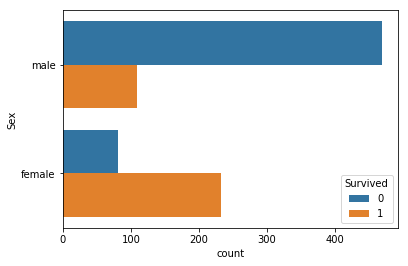

In [15]:
print(train_data['Sex'].value_counts())
sns.countplot(y=train_data['Sex'],hue=train_data['Survived'])
###No missing values in the 'Sex' column, convert the values to 0/1 and add to data_bins

In [16]:
#data_bins['Sex'] = np.where(train_data['Sex']=='female',1,0)
data_bins['Sex'] = train_data['Sex']
data_bins.head()

,Survived,Pclass,Title,Sex
0,0,3,Mr,male
1,1,1,Mrs,female
2,1,3,Miss,female
3,1,1,Mrs,female
4,0,3,Mr,male


In [17]:
avg_age_title = {}
for title in pd.unique(train_data['title']):
    avg_age_title[title] = np.mean(train_data[train_data['title']==title]['Age'])

###Add age to data_bins
data_bins['Age'] = train_data['Age']

age=list()
###now fill the NAN in Age with the average of all people having the same title
for ind in list(train_data[(train_data['Age'].isna()==True)].index):
    data_bins['Age'][ind]=avg_age_title[train_data.loc[ind]['title']]


/Users/gurumanikanta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [18]:
data_bins['Age'] = data_bins['Age'].apply(lambda val: np.ceil(val))
data_bins['Age'] = data_bins['Age'].astype(int)
data_bins.head()

,Survived,Pclass,Title,Sex,Age
0,0,3,Mr,male,22
1,1,1,Mrs,female,38
2,1,3,Miss,female,26
3,1,1,Mrs,female,35
4,0,3,Mr,male,35


(16.8, 32.6]    382
(32.6, 48.4]    325
(0.92, 16.8]    104
(48.4, 64.2]     69
(64.2, 80.0]     11
Name: Age, dtype: int64


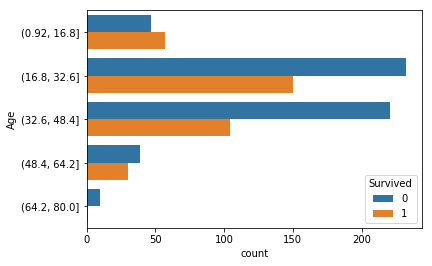

In [19]:
###create buckets of age - 0-10,11-20,...
data_bins['Age'] = pd.cut(data_bins['Age'],5,include_lowest=True)
print(data_bins['Age'].value_counts())
sns.countplot(data=data_bins,y='Age',hue='Survived')

data_bins['Age'] = data_bins['Age']

In [20]:
###No null values in either of the fields - SibSp, Parch. Add them to the data_bins
print('SibSp null values: {0}'.format(train_data['SibSp'].isna().sum()))
print('Parch null values: ',train_data['Parch'].isna().sum())
data_bins['SibSp'] = train_data['SibSp']
data_bins['Parch'] = train_data['Parch']

SibSp null values: 0
Parch null values:  0


/Users/gurumanikanta/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


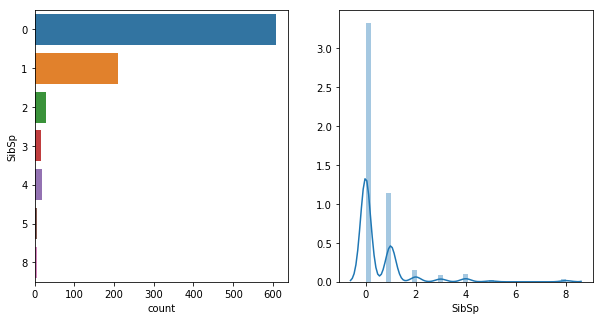

In [21]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.countplot(y=data_bins['SibSp'])
plt.subplot(1,2,2)
sns.distplot(data_bins['SibSp'])

In [22]:
###Doesn't seem like there are any patterns for the ticket and it has 681 unique values out of 891 total values
###The ticket field will not be a good fit for the model
train_data['Ticket'].value_counts()

347082           7
CA. 2343         7
1601             7
CA 2144          6
347088           6
3101295          6
382652           5
S.O.C. 14879     5
347077           4
19950            4
349909           4
17421            4
PC 17757         4
W./C. 6608       4
113781           4
4133             4
113760           4
2666             4
LINE             4
C.A. 31921       3
110413           3
239853           3
PC 17582         3
F.C.C. 13529     3
24160            3
13502            3
PC 17755         3
SC/Paris 2123    3
C.A. 34651       3
345773           3
                ..
330919           1
7545             1
110564           1
111240           1
347076           1
13509            1
371362           1
C 7075           1
PC 17605         1
3101264          1
11769            1
371060           1
347470           1
113050           1
345781           1
349207           1
367229           1
350417           1
PC 17599         1
34218            1
111320           1
349241      

In [23]:
###In general the price would be based on class, so price and class could have almost similar relation to survival
###Price field has many different values for prices, these prices will be binned and encoded to a computer understandable format
train_data['Fare'].value_counts()
max(train_data['Fare'])
min(train_data['Fare'])

0.0

(0, 10]       321
(10, 20]      179
(20, 35]      178
(35, 60]       76
(60, 80]       48
(100, 200]     33
(80, 100]      21
(200, 300]     17
(400, 515]      3
(300, 400]      0
Name: Fare, dtype: int64

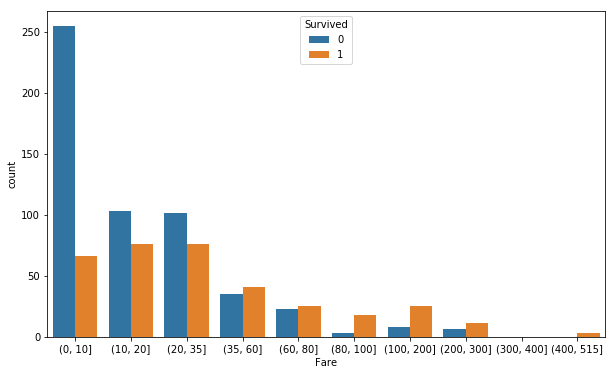

In [24]:
plt.figure(figsize=(10,6))
data_bins['Fare'] = pd.cut(train_data['Fare'],[0,10,20,35,60,80,100,200,300,400,515])
sns.countplot(data_bins['Fare'],hue=data_bins['Survived'])
data_bins['Fare'].value_counts()

###Ratio of perished to survived in the price range 0-10 is the highest
###As the ticket price increases this ratio gets better

In [25]:
###No nulls in Fare field, add it to the data_bins
data_bins['Fare'] = data_bins['Fare']

In [26]:
###The cabin feature has more missing values than not, we can not use a fill method on it. This field can not make model better
###Embarked has 2 null values, we will use back-fill for now. We can encode the values and use it in the model
train_data['Embarked'].value_counts()
data_bins['Embarked'] = train_data['Embarked']
data_bins['Embarked'].fillna(method = 'backfill',inplace = True)
data_bins['Age'] = data_bins['Age'].astype(str)
data_bins['Fare'] = data_bins['Fare'].astype(str)
data_bins.head()

,Survived,Pclass,Title,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,Mr,male,"(16.8, 32.6]",1,0,"(0, 10]",S
1,1,1,Mrs,female,"(32.6, 48.4]",1,0,"(60, 80]",C
2,1,3,Miss,female,"(16.8, 32.6]",0,0,"(0, 10]",S
3,1,1,Mrs,female,"(32.6, 48.4]",1,0,"(35, 60]",S
4,0,3,Mr,male,"(32.6, 48.4]",0,0,"(0, 10]",S


In [32]:
###We will also store a copy of the originally processed dataframe
data_processed = data_bins.copy()
###We will store a copy of data_bins in another dataframe to OneHotEncode
data_ohe = data_bins.copy()
data_ohe = pd.get_dummies(data_ohe)
data_ohe.tail()

,Survived,Pclass,SibSp,Parch,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Top,Sex_female,...,"Fare_(20, 35]","Fare_(200, 300]","Fare_(35, 60]","Fare_(400, 515]","Fare_(60, 80]","Fare_(80, 100]",Fare_nan,Embarked_C,Embarked_Q,Embarked_S
886,0,2,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
887,1,1,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
888,0,3,1,2,0,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
889,1,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
890,0,3,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [33]:
###we will have to convert the ranges and text to some computer understandable format - 0,1,2,...
le = LabelEncoder()
data_bins[['Title','Sex','Age','Fare','Embarked']] = data_bins[['Title','Sex','Age','Fare','Embarked']].apply(le.fit_transform)
data_bins.tail()

,Survived,Pclass,Title,Sex,Age,SibSp,Parch,Fare,Embarked
886,0,2,4,1,1,0,0,1,2
887,1,1,1,0,1,0,0,3,2
888,0,3,1,0,1,1,2,3,2
889,1,1,2,1,1,0,0,3,0
890,0,3,2,1,1,0,0,0,1


In [38]:
def run_model(name,X_train,y_train,cv):
    '''Applies the model specified in NAME on the X_train, y_train
    with cross-validation #cv times and to the NAME model individually, 
    returns accuracy for both'''
    
    #running the model once
    model = name.fit(X_train,y_train)
    accuracy = round(model.score(X_train,y_train)*100,2)
    
    #running cross validation model
    cv_pred = model_selection.cross_val_predict(name, X_train, y_train,
                                                cv = cv, n_jobs = -1)
    cv_accuracy = round(metrics.accuracy_score(cv_pred,y_train)*100,2)
    
    return accuracy, cv_accuracy

In [41]:
X_train = data_bins.loc[:,'Pclass':'Embarked']
y_train = data_bins['Survived']
acc, cv_acc = run_model(LogisticRegression(),X_train,y_train,10)

print('LabelEncoded data performance')
print('Accuracy - LogisticRegression without CV: {}'.format(acc))
print('Accuracy - LogisticRegression with CV: {}'.format(cv_acc))

LabelEncoded data performance
Accuracy - LogisticRegression without CV: 79.91
Accuracy - LogisticRegression with CV: 79.12


/Users/gurumanikanta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [39]:
X_train = data_ohe.drop('Survived',axis=1)
y_train = data_ohe['Survived']
acc, cv_acc = run_model(LogisticRegression(),X_train,y_train,10)

print('OHE data performance')
print('Accuracy - LogisticRegression without CV: {}'.format(acc))
print('Accuracy - LogisticRegression with CV: {}'.format(cv_acc))

Accuracy - LogisticRegression without CV: 83.5
Accuracy - LogisticRegression with CV: 82.72


/Users/gurumanikanta/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Logistic Regression - Conclusion
*Using dummy variables gives better performance than using LableEncoder*

**--------------------------------------------------------------------------------------------------------**